Download pre-trained Word2Vec model


In [2]:
import matplotlib.pyplot as plt

In [3]:
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

corpus = api.load('text8')
model = Word2Vec(corpus)

[==================================================] 100.0% 31.6/31.6MB downloaded


Getting embedding of a sentence

In [4]:
import numpy as np

def get_sentence_embedding(model, text):
  # This method takes in the trained model and the input sentence
  # and returns the embedding of the sentence as the average embedding
  # of its words
  words = text.split(" ")
  count = 0
  for i in range(1, len(words)):
    try:
      if count == 0:
        vector = model.wv[words[i]]
      else: 
        vector = np.copy(vector+model.wv[words[i]])
      count+=1
    except:
      continue
  return vector/count

# Sample code to extract vector for a sentence
get_sentence_embedding(model, "test text embedding")

array([ 0.2886807 , -0.05604353,  0.2427635 , -0.52148056, -1.387321  ,
       -0.5418588 ,  0.01500472, -0.28544796, -0.9957545 ,  0.72377634,
        1.031291  , -0.9663507 , -0.6978948 , -0.09655653, -0.40107417,
        1.3504831 ,  1.7954043 , -2.1389918 , -0.14029476, -0.26009285,
       -1.7889875 , -1.0005177 ,  0.89141464, -0.11038665, -0.3640019 ,
        1.0050242 , -0.6783414 , -1.3653326 , -1.2587733 , -0.00883579,
        0.8720209 , -0.39895222,  0.13008142,  0.0852837 ,  0.7190679 ,
        1.2585268 ,  0.515551  , -0.25278878, -0.65387595, -0.1461887 ,
       -1.320362  , -0.6567309 , -0.44155377, -0.6486351 ,  1.2184979 ,
       -0.5824977 ,  0.06534742,  0.5043694 , -1.7968801 , -0.60738087,
        0.70663273,  0.33976236, -1.0519199 , -0.05766847, -0.41744086,
       -0.36175987, -0.00911653, -0.19504905,  0.34414136, -0.02414912,
        0.58944136,  0.38714272,  0.0806376 ,  0.7911715 ,  0.81166154,
       -0.6850153 ,  0.20673302,  0.8385984 , -0.15719458, -0.04

Reading TSV file and saving embeddings

In [5]:
import pandas as pd

def read_tweets_get_vectors(tweet_file_path):
  # This method takes in the file path for the twitter file, and return a
  # dicationary of dictionaries. In the first dictionary the keys are the
  # tweet labels (3 classes), and the values are another dictionary with
  # tweet id as the key and values are tuple of (vector, tweet text)
    df = pd.read_csv(tweet_file_path, sep=',', header=0)
    dic_result = {}
    df1 = df[['tweet_id', 'text', 'airline_sentiment']]
    for index in range(len(df1)):
        try:
            vetor_rep = get_sentence_embedding(model, df.loc[index, "text"].lower())
            label = df.loc[index, "airline_sentiment"]
            tweet_id = df.loc[index, "tweet_id"]
            if label in dic_result:
                dic_result[label][tweet_id] = (vetor_rep, df.loc[index, "text"].lower())
            else:
                dic_result[label] = {tweet_id: (vetor_rep, df.loc[index, "text"].lower())}
        except:
            pass
    return dic_result, df

twitter_data, twitter_data_df = read_tweets_get_vectors("Tweets.csv")
#for key in twitter_data.keys():
#  print(key + "\t\t number of instances: " + str(len(twitter_data[key])))

In [6]:
twitter_data_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Code to generate training, validation, and test sets

In [7]:
import random

def split_data(twitter_data):
  # takes in the dictionary from the previous step and generate
  # the training, validation, and test sets. Note that the labels 
  # are represented as one-hot codings.
    training_x = []
    training_y = []

    validation_x = []
    validation_y = []

    test_x = []
    test_y = []

    for label in twitter_data:

        # labels are indicated as one hot coding [negative, neutral, positive]
        if label == "negative":
            n_label = [1, 0, 0]
        elif label == "neutral":
            n_label = [0, 1, 0]
        else:
            n_label = [0, 0, 1]
        temp_dic = twitter_data[label]
        lst_tweet_ids = list(temp_dic.keys())
        #### Splitting by 80-10-10
        ## Note that you could alternatively use sklearn split method
        train_length = int(len(lst_tweet_ids)*0.8)
        train_ids = lst_tweet_ids[ :train_length]
        remaining = lst_tweet_ids[train_length:]
        test_lenght = int(len(remaining)*0.5)
        test_ids = remaining[:test_lenght]
        validation_id = remaining[test_lenght:]

        for tweet_id in train_ids:
            training_x.append(temp_dic[tweet_id][0])
            training_y.append(n_label)
        for tweet_id in validation_id:
            validation_x.append(temp_dic[tweet_id][0])
            validation_y.append(n_label)
        for tweet_id in test_ids:
            test_x.append(temp_dic[tweet_id][0])
            test_y.append(n_label)

    # The reason we apply this shuffling is to make sure 
    # when passing batches to the network, we see different items 
    c = list(zip(training_x, training_y))
    random.shuffle(c)
    training_x, training_y = zip(*c)

    return training_x, training_y, validation_x, validation_y, test_x, test_y

# Sample usage
training_x, training_y, validation_x, validation_y, test_x, test_y = split_data(twitter_data)

Here goes your code for your Feedfoward network Design

In [46]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch


class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, output_dim, dropout_rate):#, weight_decay):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Define layers

        # Linear function and ReLU as activation function
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1)
        self.tanh_1 = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        # Another linear function and ReLU as activation function
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.tanh_2 = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        # Another linear function
        self.layer_3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.relu_3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        # Another linear function
        self.layer_4 = nn.Linear(hidden_dim_3, output_dim)

    def forward(self, x):
        # Your network forward pass
        out = self.layer_1(x)
        out = self.tanh_1(out)
        out = self.dropout(out)
        out = self.layer_2(out)
        out = self.tanh_2(out)
        out = self.dropout(out)
        out = self.layer_3(out)
        out = self.relu_3(out)
        out = self.dropout(out)
        out = self.layer_4(out)
        return torch.sigmoid(out)

Training the network
Define a class, with properties such as size of hidden layers
loss function, optimizer, training method, test method, and accuracy

In [49]:
from tqdm import tqdm

class ModelModule():
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # hyper parameters
  input_dim = 100
  hidden_dim_1 = 256
  hidden_dim_2 = 128
  hidden_dim_3 = 32
  out_dim = 3
  dropout_rate = 0.5
   
  model = FeedforwardNeuralNetModel(input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, out_dim, dropout_rate)

  # loss function
  criterion = nn.CrossEntropyLoss()

  # optimizer
  optimizer = optim.Adam(model.parameters(), lr=0.0001)

  # moving to GPU if available
  model.to(device)
  criterion = criterion.to(device)


  def calculate_accuracy(self, y_true, y_pred):
    # this method will be used to calculate the accuracy of your model
    correct = (y_true.argmax (dim = 1) == y_pred.argmax (dim = 1)).float()
    acc = correct.sum() / len(correct)
    return acc

  def training(self, tfidfX_train, Y_train, tfidfX_val, Y_val, num_epochs):
    # this method will be used for training your model
    # inputs are the training and validation sets

    batch_size = 64
    X_train_mini_batches = torch.split(tfidfX_train, batch_size)
    Y_train_mini_batches = torch.split(Y_train, batch_size)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_accuracy = 0

    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        epoch_accuracy = 0
        for X_train_mini_batch, Y_train_mini_batch in zip(X_train_mini_batches, Y_train_mini_batches):
            X_train_mini_batch = X_train_mini_batch.to(self.device)
            Y_train_mini_batch = Y_train_mini_batch.to(self.device)
            # Continue code here to train the network
            # forward pass
            train_prediction = self.model.forward(X_train_mini_batch.float())

            # returns a tensor with all the dimensions of input of size 1 removed
            train_prediction = torch.squeeze(train_prediction)

            # calculate loss
            train_loss = self.criterion(train_prediction, Y_train_mini_batch.squeeze())
            # train_loss += self.weight_decay * torch.sum(self.model.layer_1.weight ** 2)
            # train_loss.backward()
            # clearing up acculated gradients
            self.optimizer.zero_grad()

            # getting gradients
            train_loss.backward()

            # updating parameters
            self.optimizer.step()

            # add each mini batch's loss
            epoch_loss += train_loss.item()

            # add each mini batch's accuracy
            epoch_accuracy += self.calculate_accuracy(Y_train_mini_batch, train_prediction)

        tfidfX_val = tfidfX_val.to(self.device)
        Y_val = Y_val.to(self.device)


        # Forward pass to get output
        val_prediction = self.model.forward(tfidfX_val.float())
        val_prediction = torch.squeeze(val_prediction)


        # Calculate Loss
        val_loss = self.criterion(val_prediction, Y_val)
        # Add each mini batch's loss
        validation_loss = val_loss.item()

        # Add each mini batch's accuracy
        val_accuracy = self.calculate_accuracy(Y_val, val_prediction)
        if val_accuracy > best_accuracy:
            torch.save(self.model.state_dict(), 'best_model_state.bin')
            # or
            # torch.save(self.model, 'best_model_state.bin')
            best_accuracy = val_accuracy
        # for generating train/validation loss plot
        epoch_loss /= len(X_train_mini_batches)
        epoch_accuracy /= len(X_train_mini_batches)
        val_losses.append(validation_loss)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        val_accuracies.append(val_accuracy)
    plt.figure(figsize=(10, 8))
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('First Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
        # here check your validation set
        # you have to save the model with the best loss or maybe accuracy?
  def __loadModel(self, ):
    self.model.load_state_dict(torch.load('best_model_state.bin'))

  def test(self, tfidfX_test, Y_test):
    self.__loadModel()
    tfidfX_test = tfidfX_test.to(self.device)
    Y_test = Y_test.to(self.device)
    # forward pass to get output
    test_prediction = self.model.forward(tfidfX_test.float())
    test_prediction = torch.squeeze(test_prediction)

    # calculate accuracy
    test_accuracy = self.calculate_accuracy(Y_test, test_prediction)

    print("Test Accuracy:", round(test_accuracy.item(), 4), "\n")

100%|██████████| 60/60 [00:32<00:00,  1.83it/s]


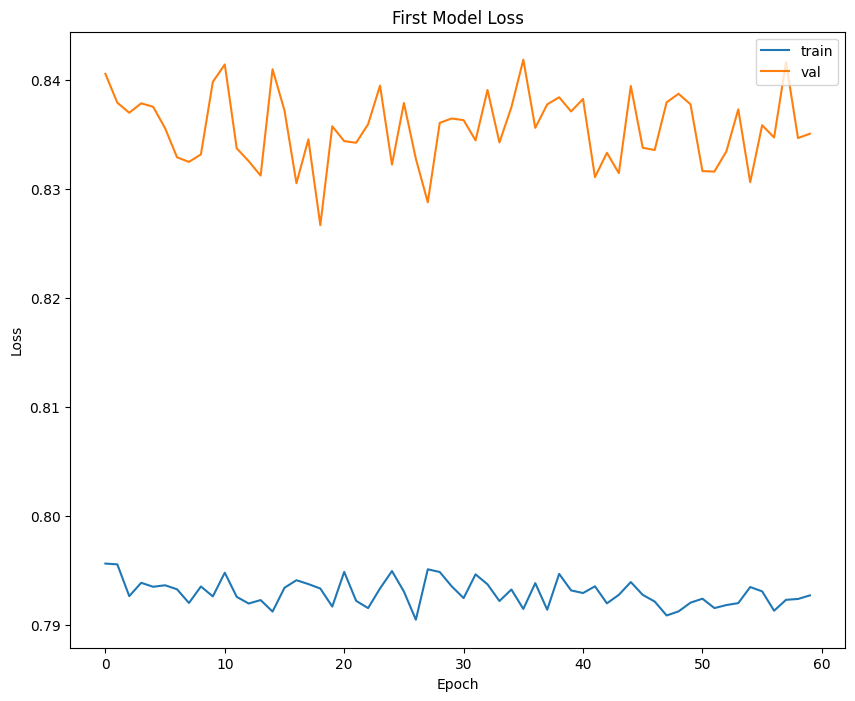

Test Accuracy: 0.7013 



In [54]:
model = ModelModule()

training_x = torch.from_numpy(np.asarray(training_x)).type(torch.FloatTensor)
training_y = torch.from_numpy(np.asarray(training_y)).type(torch.FloatTensor)

validation_x = torch.from_numpy(np.asarray(validation_x)).type(torch.FloatTensor)
validation_y = torch.from_numpy(np.asarray(validation_y)).type(torch.FloatTensor)

# make sure the labels are valid indices for the model's output
num_classes = 3

model.training(training_x, training_y, validation_x, validation_y, 100)

testing_x = torch.from_numpy(np.asarray(test_x)).type(torch.FloatTensor)
testing_y = torch.from_numpy(np.asarray(test_y)).type(torch.FloatTensor)
model.test(testing_x, testing_y)